In [1]:
from __future__ import unicode_literals
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn

In [2]:
df = pd.read_csv('aggregation.csv')
df.head()

,text,retweet_count,favorite_count,username,userdesc,verified,followers,created_at,has_urls,has_mentions,high_response
0,They are starting to get more and more despera...,24298,168648,GretaThunberg,17 year old climate and environmental activist...,True,4079169,2020-02-29 15:26:10,True,False,True
1,I do not believe we will defeat Donald Trump w...,18592,77895,BernieSanders,U.S. Senator from Vermont and candidate for Pr...,True,10951634,2020-03-02 20:30:56,False,False,True
2,Indigenous rights = Climate justice\n#Wetsuwet...,4609,21488,GretaThunberg,17 year old climate and environmental activist...,True,4086646,2020-02-08 13:36:48,True,False,True
3,Stop running away from your problem. Run into ...,2739,16317,pulte,The Philanthropist. Inventor of Twitter Philan...,True,2059165,2020-02-29 21:19:22,True,False,True
4,Support the Wet’suwet’en Nation and the pipeli...,2972,10035,GretaThunberg,17 year old climate and environmental activist...,True,4091979,2020-02-18 10:13:02,True,False,True


In [3]:
from sklearn.pipeline import Pipeline

# Tutorials:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [4]:
tweet_corpus = list(df['text'])

In [5]:
# Remove URL junk
url_pattern = re.compile("http[^\s]+", re.I)

for i in range(len(tweet_corpus)):
    tweet_corpus[i] = url_pattern.sub('', tweet_corpus[i])

In [6]:
print(tweet_corpus[:5])

['They are starting to get more and more desperate...\nThis shows that we’re winning. ', 'I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the Iraq War. ', 'Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround ', 'Stop running away from your problem. Run into your problem.  It will suck.  Really suck. But, when you pop out the… ', 'Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStrong  ']


In [ ]:
hashtag_pattern = re.compile("#[^\s]+", re.I)

for i in range(20):
    matches = hashtag_pattern.findall(tweet_corpus[i])
    if matches:
        print(matches)

In [7]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

add_stop_words = ['wetsuweten', 'wet', 'suwet', 'en',
                  'wetsuwetenstrong', 'wetsuwetensolidarity', 'shutdowncanada',
                    'bc', 'british', 'columbia', 'canada', 'indigenous', 'pipeline']

custom_stop_words = set(ENGLISH_STOP_WORDS).union(set(add_stop_words))

In [10]:
bigram_vect = CountVectorizer(stop_words=custom_stop_words,
                             analyzer='word', ngram_range=(2,2))
bigrams = bigram_vect.fit_transform(tweet_corpus)

In [11]:
print("Bigrams:", len(bigram_vect.get_feature_names()))

1-grams: 8396
Bigrams: 23987


In [12]:
bigrams = TfidfTransformer().fit_transform(bigrams) # Text frequency*Inverse document frequency matrix

In [13]:
# Dimensionality reduction for latent semantic analysis
svd = TruncatedSVD(n_components=100) # Recommended param for TfIdf matrix
normalizer = Normalizer(copy=False)
lsa = Pipeline([
    ('truncated_SVD', svd), 
    ('normalizer', normalizer)
    ])

In [14]:
bigrams = lsa.fit_transform(bigrams)

In [34]:
km = KMeans(3) # default: n_clusters=8, max_iter=300, n_init=10

In [35]:
km.fit(bigrams)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
terms = bigram_vect.get_feature_names()

# with SVD
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
# without SVD
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(km.n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print('   %s' % terms[ind], end='')
        print()

Cluster 0:   rule law   bcpoli cdnpoli   hurting ajenglish   blockade caledonia   spent time   hereditary chief   land water   solidarity land   climate change   support land
Cluster 1:   land defenders   coastal gaslink   proposed agreement   don know   prime minister   justin trudeau   joint statement   action solidarity   chief woos   canadian government
Cluster 2:   hereditary chiefs   agreement hereditary   chiefs amp   tentative agreement   amp canadian   pressure tentative   canadian gov   chiefs say   chiefs canadian   solidarity hereditary


In [37]:
labels = km.labels_.tolist() # [0,1,2...]

In [38]:
km_df_cols = {'user': df['username'], 'text': df['text'], 
              'label': labels}
km_df = pd.DataFrame(km_df_cols)
km_df.head()

,user,text,label
0,GretaThunberg,They are starting to get more and more despera...,0
1,BernieSanders,I do not believe we will defeat Donald Trump w...,1
2,GretaThunberg,Indigenous rights = Climate justice\n#Wetsuwet...,0
3,pulte,Stop running away from your problem. Run into ...,0
4,GretaThunberg,Support the Wet’suwet’en Nation and the pipeli...,1


In [39]:
grouped = km_df.groupby(km_df['label'])
grouped.size() # tweets in each group

label
0    1406
1    2585
2     228
dtype: int64

In [40]:
non_ascii_pattern = re.compile("[^\u0000-\u2300]") # source https://stackoverflow.com/questions/2124010/grep-regex-to-match-non-ascii-characters
# ellipsis: "\u2026"; currency symbols later

for i in range(200):
    if non_ascii_pattern.search(tweet_corpus[i]):
        print((non_ascii_pattern.findall(tweet_corpus[i])[0]))

👉
👉
✊
❌
✊
🔥


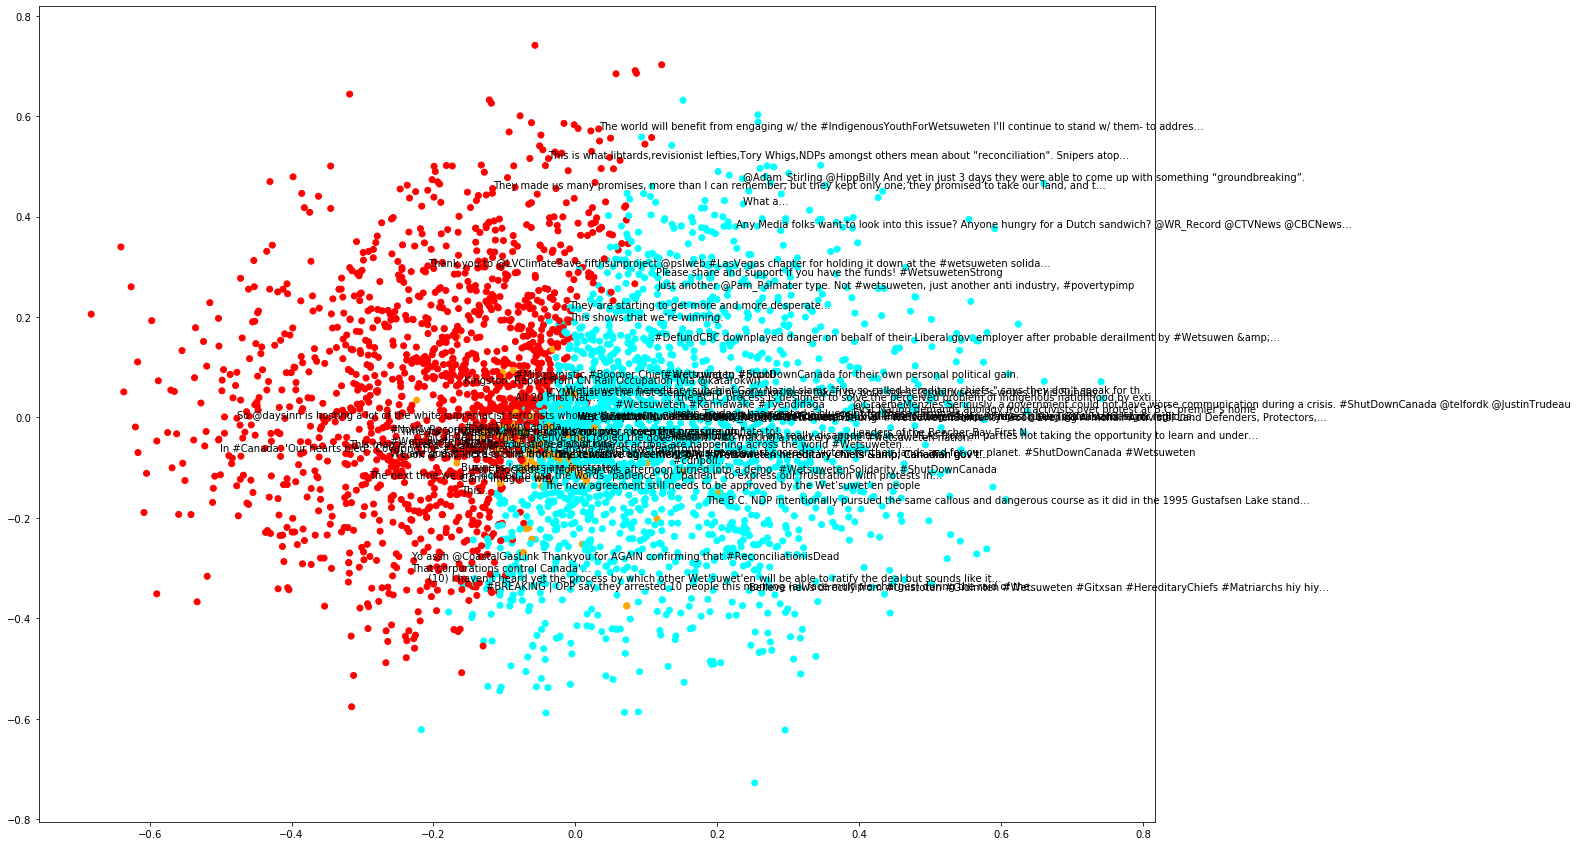

In [47]:
pca = PCA(n_components=2) # Principal Component Analysis: reduce to 2D space
                          # only for sparse input, i.e. SVD
scatter_plot_points = pca.fit_transform(bigrams)

colors = ["red", "cyan", "orange", "blue"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in km.labels_])

for i, txt in enumerate(tweet_corpus):
    if i % 100 != 0:
        continue
    if non_ascii_pattern.search(txt):
        txt = non_ascii_pattern.sub('', txt)
    ax.annotate(txt, (x_axis[i], y_axis[i]))